In [2]:
import os, sys

import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from scipy.optimize import curve_fit
from datetime import datetime, timedelta

import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from matplotlib import pyplot as plt
import seaborn as sns

import pickle as pkl
from scipy.io import loadmat
from astropy.time import Time
from astropy.coordinates import get_sun

In [3]:
def rmse(pred, true):
    return np.sqrt(mean_squared_error(pred, true))

In [4]:
df = pd.read_csv('../data/bdt_training/April17mix_cleaned.csv')

In [5]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [6]:
features = []

proxy_prefix = ['average', 'std', 'min', 'max']
proxy_vars = ['ap_index_nT', 'f10.7_index', 'Lyman_alpha']

df = df[((df['altitude']<2e3) & (df['latitude']<180) & (df['longitude']<360) & (df.density_orbitmean<1.0))]

for p in proxy_prefix:
    for f in proxy_vars:
        varname = '{}_{}'.format(p, f)
        features.append(varname)
features = features + ['altitude', 'latitude', 'longitude']
#df = df[features + ['density_orbitmean']]

In [7]:
col_ranges = {
    'altitude': (0, 1000),
    'latitude': (-90, 90),
    'longitude': (-180, 180),
    'average_ap_index_nT': (0, 400),
    'average_f10.7_index': (0, 200),
    'average_Lyman_alpha': (0, 0.1),
    'std_ap_index_nT': (0, 400),
    'std_f10.7_index': (0, 200),
    'std_Lyman_alpha': (0, 0.1),
    'min_ap_index_nT': (0, 400),
    'min_f10.7_index': (0, 200),
    'min_Lyman_alpha': (0, 0.1),
    'max_ap_index_nT': (0, 400),
    'max_f10.7_index': (0, 200),
    'max_Lyman_alpha': (0, 0.1)
}

In [8]:
# transform the input features
for col_ in col_ranges:
    min_, max_ = col_ranges[col_]
    df[col_] = (df[col_]-min_)/(max_-min_)

In [14]:
print(len(df))
size = len(df)

# Define AP index bins and labels
geo_act_bins = [0, 32, 65, 95, 155, 300, float('inf')]
geo_act_labels = ["0-32", "33-65", "66-94", "95-155", "156-301", ">302"]

# Define altitude bins and labels
alt_bins = [200, 400, 600]
alt_labels = ['0-200', '201-400', '401-600', '601-800', '801-1000']

for i in range(len(alt_bins)-1):
    alt_filter = (df['altitude']*1e3>=alt_bins[i]) & (df['altitude']*1e3<alt_bins[i+1])
    for j in range(len(geo_act_bins)-1):
        # geo_act_filter = (df['average_ap_index_nT']>=geo_act_bins[j]) & (df['average_ap_index_nT']<geo_act_bins[j+1])
        geo_act_filter = (df['ap_index_nT']>=geo_act_bins[j]) & (df['ap_index_nT']<geo_act_bins[j+1])
        bin_filter = alt_filter & geo_act_filter
        print(str(len(df[bin_filter]))+' ', end='')
    print()

1317939
103342 4068 715 315 206 111 
1151492 46238 8287 2049 935 181 


In [17]:
# Initialize logs
rmse_log = []
data_log = []
results = {} # Stores training evaluation history

# Iterate over altitude and geomagnetic activity bins
for i in range(len(alt_bins) - 1):
    # Skip first two altitude bins

    alt_filter = (
        (df['altitude'] * 1e3 >= alt_bins[i]) &
        (df['altitude'] * 1e3 < alt_bins[i + 1])
    )

    for j in range(len(geo_act_bins) - 1):
        geo_act_filter = (
            (df['ap_index_nT'] >= geo_act_bins[j]) &
            (df['ap_index_nT'] < geo_act_bins[j + 1])
        )
        bin_filter = alt_filter & geo_act_filter

        X = df[bin_filter][features].to_numpy()
        y = (df[bin_filter]['density_orbitmean'] * 1e12).to_numpy()

        if len(X) == 0:
            print(f"No data for alt_bin: {alt_bins[i]} - {alt_bins[i+1]}, "
                  f"geomagnetic_activity_bin: {geo_act_bins[j]} - {geo_act_bins[j+1]}")
            continue

        data_log.append(len(X))

        # Train/Validation/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train, y_train, test_size=0.25, random_state=42
        )

        # Initialize model
        model = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=10,
            colsample_bytree=0.67,
            min_child_weight=0.8,
            reg_lambda=0.0266
        )

        # Train and log evaluation history
        res = model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=False
        )

        # Store results
        results[10 * i + j] = res

        # Compute RMSE
        y_pred_test = model.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_log.append(np.sqrt(mse_test))

        # Optional: Save model
        model.save_model(f'AP_{geo_act_labels[j]}_Alt_{alt_labels[i]}')

/home/oem/anaconda3/envs/ml/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:31:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/home/oem/anaconda3/envs/ml/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:31:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/home/oem/anaconda3/envs/ml/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:31:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/home/oem/anaconda3/envs/ml/lib/python3.9/site-packages/xgboo

In [19]:
for i in range(2):
    for j in range(6):
        print(str(rmse_log[3*i+j])+'\t', end='')
    print()

0.10102270884243775	0.18555062322772675	0.04406178781089747	0.043184801853472066	0.13329670300912774	0.017628775253532857	
0.043184801853472066	0.13329670300912774	0.017628775253532857	0.06534397587975473	0.06959942038503095	0.11719471831346813	


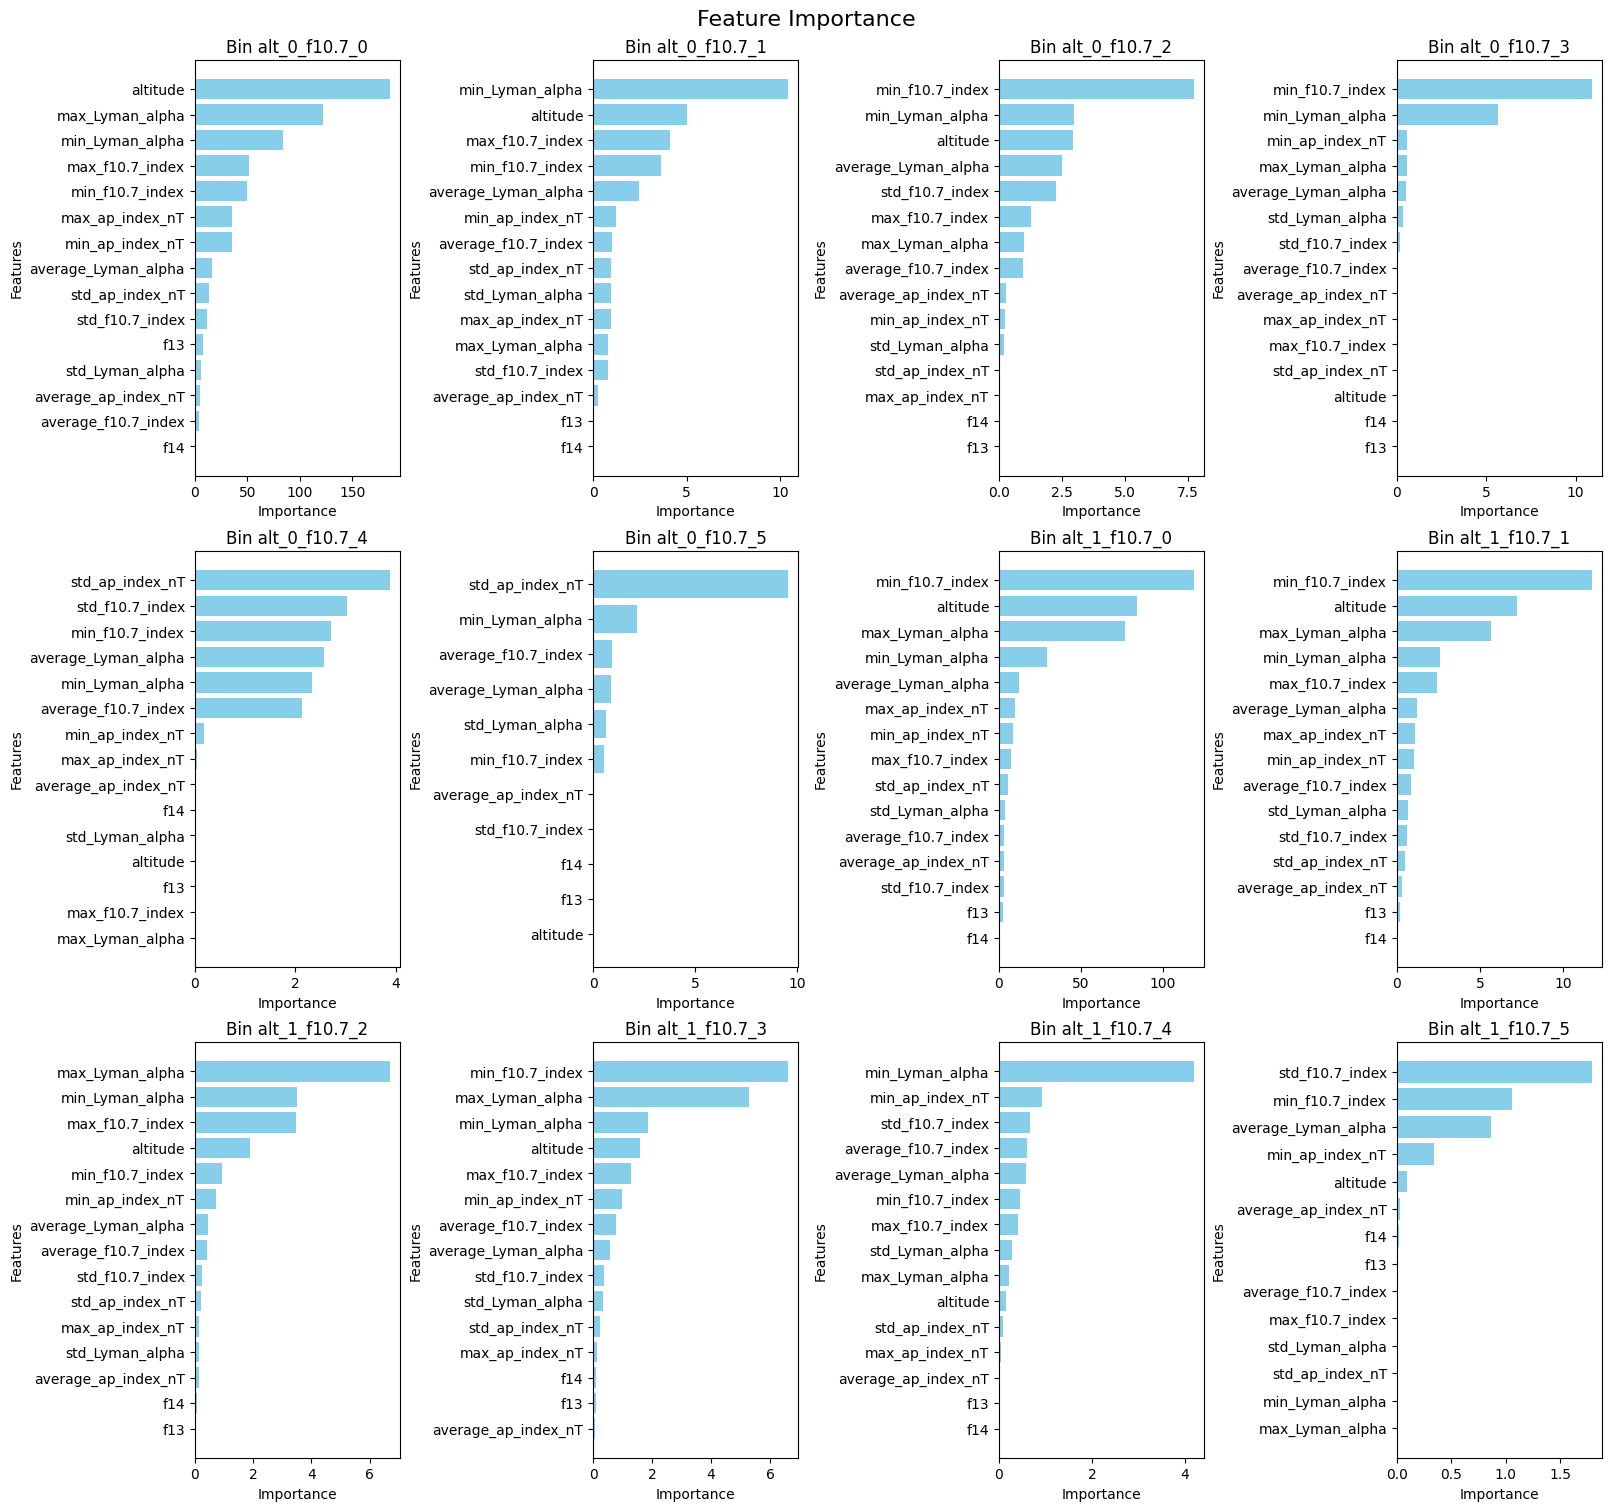

In [23]:
# Number of plots (one per bin that had data)
n_plots = len(rmse_log)

# Compute grid size (square-ish layout)
cols = math.ceil(math.sqrt(n_plots))
rows = math.ceil(n_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 5 * rows), constrained_layout=True)

idx = -1 # initialize plot index

# Epochs
epochs = np.arange(0,100)

# Plot each training/validation loss curve
for i in range(len(alt_bins) - 1):
    for j in range(len(geo_act_bins) - 1):
        idx += 1
        irow = idx//4
        jcol = idx%4
        ax = axes[irow][jcol]

        # Get feature list
        features = []
        proxy_prefix = ['average', 'std', 'min', 'max']
        proxy_vars = ['ap_index_nT', 'f10.7_index', 'Lyman_alpha']
        
        for p in proxy_prefix:
            for f in proxy_vars:
                varname = '{}_{}'.format(p, f)
                features.append(varname)
        features += ['altitude']

        feature_importance = results[10 * i + j].get_booster().get_score(importance_type="gain")
        
        # Define a dictionary to replace feature names
        feature_name_mapping = {}
        
        for if_, f_ in enumerate(features):
            feature_name_mapping[f'f{if_}'] = features[if_]
        
        # Replace feature names using the dictionary
        updated_feature_importance = {
            feature_name_mapping.get(k, k): v for k, v in feature_importance.items()
        }
        
        # Sort updated features by importance
        sorted_features = sorted(updated_feature_importance.items(), key=lambda x: x[1], reverse=True)
        
        # Plot the updated feature importance
        features, importances = zip(*sorted_features)
        ax.barh(features, importances, color="skyblue")
        ax.set_xlabel("Importance")
        ax.set_ylabel("Features")
        ax.invert_yaxis()
        ax.set_title(f"Bin alt_{i}_f10.7_{j}")
        #ax.grid(True)

# Show the full figure
plt.suptitle("Feature Importance", fontsize=16)

plt.savefig('feature_importance_xgb_v12.png', bbox_inches='tight', dpi=100)
plt.show()
plt.close()